In [27]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score,train_test_split, KFold, cross_val_predict
from sklearn.metrics import mean_squared_error,r2_score,roc_curve,auc,precision_recall_curve, accuracy_score, \
recall_score, precision_score, confusion_matrix, make_scorer
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, ParameterGrid, StratifiedKFold, RandomizedSearchCV
from sklearn.ensemble import VotingRegressor, VotingClassifier, StackingRegressor, StackingClassifier, GradientBoostingRegressor,GradientBoostingClassifier, BaggingRegressor,BaggingClassifier,RandomForestRegressor,RandomForestClassifier,AdaBoostRegressor,AdaBoostClassifier
from sklearn.linear_model import LinearRegression,LogisticRegression, LassoCV, RidgeCV, ElasticNetCV
from sklearn.neighbors import KNeighborsRegressor
import itertools as it
import time as time
import xgboost as xgb
from pyearth import Earth

In [207]:
nba_2017 = pd.read_csv('archive-2/NBA Players Stats 201718.csv')
nba_2017['Player'] = nba_2017['Player'].str.split('\\').str[0]
duplicated_players = nba_2017['Player'].duplicated(keep=False)

mask = duplicated_players & (nba_2017['Tm'] == 'TOT')


filtered_df = nba_2017[mask]


single_team_df = nba_2017[~duplicated_players]


nba_2017_2018 = pd.concat([filtered_df, single_team_df])
nba_2017_2018 = nba_2017_2018.reset_index(drop=True)
nba_2017_2018 = nba_2017_2018.drop(columns=['Rk','Tm', 'Pos'], axis=1)
nba_2017_2018.fillna(0, inplace=True)
nba_2017_2018 = nba_2017_2018[nba_2017_2018['G'] >= 20]
nba_2017_2018 = nba_2017_2018.reset_index(drop=True)

percentage_columns = ['FG%', '3P%', '2P%', 'eFG%', 'FT%']
for col in percentage_columns:
    nba_2017_2018[col] = nba_2017_2018[col] * 100

all_star_list = ['Kemba Walker', 'Kyrie Irving', 'Kawhi Leonard', 'Giannis Antetokounmpo', 
                'Joel Embiid', 'Kyle Lowry', 'Victor Oladipo', 'Khris Middleton', 'Bradley Beal',
                'Ben Simmons', 'Blake Griffin', 'Nikola Vučević', "D'Angelo Russell",
                'Stephen Curry', 'James Harden', 'Kevin Durant', 'Paul George', 'LeBron James',
                'Russell Westbrook', 'Damian Lillard', 'Klay Thompson', 'Anthony Davis', 
                'LaMarcus Aldridge', 'DeMarcus Cousins', 'Nikola Jokić', 'Karl-Anthony Towns']
nba_2017_2018['AS_NY'] = nba_2017_2018['Player'].apply(lambda x: 1 if x in all_star_list else 0)

In [208]:
nba_2017_2018.head()

,Player,Age,G,GS,MP,FG,FGA,FG%,3P,3PA,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,AS_NY
0,Luke Babbitt,28,50,14,14.3,1.8,4.3,42.3,1.2,3.1,...,0.1,1.8,1.9,0.6,0.2,0.1,0.4,1.1,5.2,0
1,Marco Belinelli,31,80,2,24.3,4.2,9.6,44.1,1.9,4.9,...,0.3,1.6,1.9,1.9,0.8,0.2,1.2,1.1,12.1,0
2,Eric Bledsoe,28,74,74,31.4,6.3,13.4,47.3,1.7,4.9,...,0.7,3.1,3.8,5.0,2.0,0.6,2.9,2.5,17.7,0
3,Trevor Booker,30,68,7,17.0,2.6,5.0,51.6,0.1,0.5,...,1.7,3.0,4.7,1.2,0.4,0.3,0.9,1.8,6.3,0
4,Avery Bradley,27,46,46,31.2,5.6,13.6,41.4,1.6,4.4,...,0.5,2.0,2.5,2.0,1.1,0.2,2.2,2.0,14.3,0


In [209]:
nba_2018 = pd.read_csv('archive-2/NBA Players Stats 201819.csv')
nba_2018['Player'] = nba_2018['Player'].str.split('\\').str[0]
duplicated_players = nba_2018['Player'].duplicated(keep=False)

mask = duplicated_players & (nba_2018['Tm'] == 'TOT')


filtered_df = nba_2018[mask]


single_team_df = nba_2018[~duplicated_players]


nba_2018_2019 = pd.concat([filtered_df, single_team_df])
nba_2018_2019 = nba_2018_2019.reset_index(drop=True)
nba_2018_2019 = nba_2018_2019.drop(columns=['Rk','Tm', 'Pos'], axis=1)
nba_2018_2019.fillna(0, inplace=True)
nba_2018_2019 = nba_2018_2019[nba_2018_2019['G'] >= 20]
nba_2018_2019 = nba_2018_2019.reset_index(drop=True)

percentage_columns = ['FG%', '3P%', '2P%', 'eFG%', 'FT%']
for col in percentage_columns:
    nba_2018_2019[col] = nba_2018_2019[col] * 100

all_star_list = ['Kemba Walker', 'Trae Young', 'Giannis Antetokounmpo', 'Pascal Siakam', 'Joel Embiid',
                'Kyle Lowry', 'Ben Simmons', 'Jimmy Butler', 'Khris Middleton', 'Bam Adebayo', 
                'Jayson Tatum', 'Domantas Sabonis', 'James Harden', 'Luka Dončić', 'LeBron James',
                'Kawhi Leonard', 'Anthony Davis', 'Chris Paul', 'Russell Westbrook', 'Damian Lillard', 
                'Donovan Mitchell', 'Brandon Ingram', 'Nikola Jokić', 'Rudy Gobert', 'Devin Booker']
nba_2018_2019['AS_NY'] = nba_2018_2019['Player'].apply(lambda x: 1 if x in all_star_list else 0)

In [210]:
nba_2018_2019.head()

,Player,Age,G,GS,MP,FG,FGA,FG%,3P,3PA,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,AS_NY
0,Ryan Anderson,30,25,8,12.9,0.8,2.8,30.4,0.4,1.6,...,0.7,1.4,2.2,0.8,0.2,0.0,0.6,1.0,2.5,0
1,Trevor Ariza,33,69,69,34.0,4.3,10.7,39.9,2.1,6.3,...,0.7,4.7,5.4,3.7,1.3,0.3,1.5,1.9,12.5,0
2,Harrison Barnes,26,77,77,32.9,5.6,13.3,42.0,2.3,5.7,...,0.7,3.9,4.7,1.5,0.6,0.2,1.3,1.6,16.4,0
3,Avery Bradley,28,63,63,30.2,3.9,9.7,40.8,1.4,3.9,...,0.7,2.1,2.8,2.4,0.7,0.3,1.4,2.7,9.9,0
4,Corey Brewer,32,31,3,15.9,1.7,4.0,43.1,0.5,1.4,...,0.8,1.6,2.5,1.3,1.0,0.2,0.6,2.0,4.9,0


**Naive Model**

In [211]:
X_train = nba_2017_2018.drop(['Player', 'AS_NY'], axis=1) 
y_train = nba_2017_2018['AS_NY']  

X_test = nba_2018_2019.drop(['Player', 'AS_NY'], axis=1)  
y_test = nba_2018_2019['AS_NY']  

y_pred = [0] * len(y_test)

accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
confusion_mat = confusion_matrix(y_test, y_pred)

print("Accuracy:", accuracy)
print("Recall:", recall)
print("Precision:", precision)
print("Confusion Matrix:")
print(confusion_mat)

Accuracy: 0.9408983451536643
Recall: 0.0
Precision: 0.0
Confusion Matrix:
[[398   0]
 [ 25   0]]


/Users/davisjohnson/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**Base Logistic Regression Model**

In [212]:
logreg = LogisticRegression(max_iter=10000)
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
confusion_mat = confusion_matrix(y_test, y_pred)

print("Accuracy:", accuracy)
print("Recall:", recall)
print("Precision:", precision)
print("Confusion Matrix:")
print(confusion_mat)

Accuracy: 0.9432624113475178
Recall: 0.6
Precision: 0.5172413793103449
Confusion Matrix:
[[384  14]
 [ 10  15]]


**Feature Importances**

In [213]:
coefficients = logreg.coef_[0]


feature_names = X_train.columns


feature_importance = sorted(zip(feature_names, coefficients), key=lambda x: abs(x[1]), reverse=True)


df_feature_importance = pd.DataFrame(feature_importance, columns=['Feature', 'Coefficient'])


df_feature_importance['Absolute Importance'] = df_feature_importance['Coefficient'].abs()
df_feature_importance = df_feature_importance.sort_values(by='Absolute Importance', ascending=False)
df_feature_importance

,Feature,Coefficient,Absolute Importance
0,AST,0.783522,0.783522
1,PTS,0.634566,0.634566
2,FTA,-0.576554,0.576554
3,FG,0.532218,0.532218
4,MP,-0.531976,0.531976
5,TRB,0.492034,0.492034
6,2P,0.464393,0.464393
7,DRB,0.431373,0.431373
8,TOV,0.421878,0.421878
9,eFG%,0.382811,0.382811


>5 0.280 (0.240)
>10 0.280 (0.240)
>50 0.200 (0.179)
>100 0.200 (0.179)
>500 0.240 (0.196)
>1000 0.240 (0.196)
>2000 0.240 (0.196)
>5000 0.240 (0.196)


Text(0.5, 0, 'Number of trees')

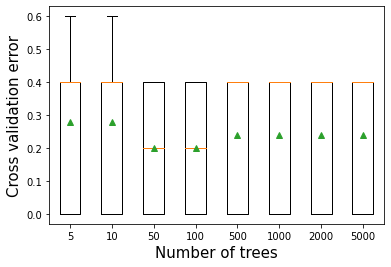

In [214]:
scale_pos_weight = np.sum(y_train == 0) / np.sum(y_train == 1)

def get_models():
    models = dict()
    # define number of trees to consider
    n_trees = [5, 10, 50, 100, 500, 1000, 2000, 5000]
    for n in n_trees:
        models[str(n)] = xgb.XGBClassifier(n_estimators=n, random_state=1, scale_pos_weight=scale_pos_weight)
    return models

# define custom scoring metric: false negative rate
def false_negative_rate(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    fnr = fn / (fn + tp)
    return fnr

# evaluate a given model using cross-validation
def evaluate_model(model, X_train, y_train):
    # define the evaluation procedure
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
    # evaluate the model and collect the results
    scoring = make_scorer(false_negative_rate, greater_is_better=True)
    scores = cross_val_score(model, X_train, y_train, scoring=scoring, cv=cv, n_jobs=-1)
    return scores

# get the models to evaluate
models = get_models()

# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    # evaluate the model
    scores = evaluate_model(model, X_train, y_train)
    # store the results
    results.append(scores)
    names.append(name)
    # summarize the performance along the way
    print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))

# plot model performance for comparison
plt.boxplot(results, labels=names, showmeans=True)
plt.ylabel('Cross validation error', fontsize=15)
plt.xlabel('Number of trees', fontsize=15)

>1 0.240 (0.150)
>2 0.240 (0.150)
>3 0.160 (0.196)
>4 0.160 (0.196)
>5 0.200 (0.179)
>6 0.200 (0.179)
>7 0.240 (0.196)
>8 0.240 (0.196)
>9 0.240 (0.196)
>10 0.240 (0.196)
>11 0.240 (0.196)
>12 0.240 (0.196)
>13 0.240 (0.196)
>14 0.240 (0.196)
>15 0.240 (0.196)
>16 0.240 (0.196)
>17 0.240 (0.196)
>18 0.240 (0.196)
>19 0.240 (0.196)
>20 0.240 (0.196)


Text(0.5, 0, 'Number of trees')

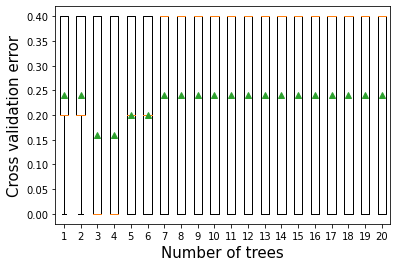

In [215]:
def get_models():
    models = dict()
    # explore depths from 1 to 10
    for i in range(1,21):
        # define ensemble model
        models[str(i)] = xgb.XGBClassifier(random_state=1,max_depth=i,scale_pos_weight=scale_pos_weight)
    return models

# define custom scoring metric: false negative rate
def false_negative_rate(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    fnr = fn / (fn + tp)
    return fnr

# evaluate a given model using cross-validation
def evaluate_model(model, X_train, y_train):
    # define the evaluation procedure
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
    # evaluate the model and collect the results
    scoring = make_scorer(false_negative_rate, greater_is_better=True)
    scores = cross_val_score(model, X_train, y_train, scoring=scoring, cv=cv, n_jobs=-1)
    return scores

# get the models to evaluate
models = get_models()

# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    # evaluate the model
    scores = evaluate_model(model, X_train, y_train)
    # store the results
    results.append(scores)
    names.append(name)
    # summarize the performance along the way
    print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))

# plot model performance for comparison
plt.boxplot(results, labels=names, showmeans=True)
plt.ylabel('Cross validation error', fontsize=15)
plt.xlabel('Number of trees', fontsize=15)

>0.0100 0.280 (0.240)
>0.0500 0.280 (0.240)
>0.1000 0.240 (0.196)
>0.2000 0.200 (0.179)
>0.3000 0.200 (0.179)
>0.4000 0.200 (0.179)
>0.5000 0.200 (0.179)
>0.6000 0.280 (0.240)
>0.8000 0.240 (0.233)
>1.0000 0.160 (0.196)


Text(0.5, 0, 'Number of trees')

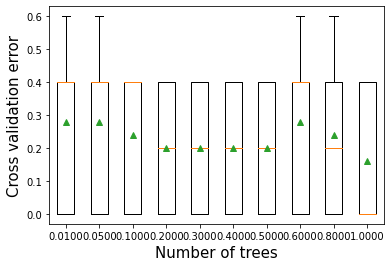

In [216]:
def get_models():
    models = dict()
    # explore learning rates from 0.1 to 2 in 0.1 increments
    for i in [0.01,0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.8,1.0]:
        key = '%.4f' % i
        models[key] = xgb.XGBClassifier(learning_rate=i,random_state=1,scale_pos_weight=scale_pos_weight)
    return models


# define custom scoring metric: false negative rate
def false_negative_rate(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    fnr = fn / (fn + tp)
    return fnr

# evaluate a given model using cross-validation
def evaluate_model(model, X_train, y_train):
    # define the evaluation procedure
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
    # evaluate the model and collect the results
    scoring = make_scorer(false_negative_rate, greater_is_better=True)
    scores = cross_val_score(model, X_train, y_train, scoring=scoring, cv=cv, n_jobs=-1)
    return scores

# get the models to evaluate
models = get_models()

# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    # evaluate the model
    scores = evaluate_model(model, X_train, y_train)
    # store the results
    results.append(scores)
    names.append(name)
    # summarize the performance along the way
    print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))

# plot model performance for comparison
plt.boxplot(results, labels=names, showmeans=True)
plt.ylabel('Cross validation error', fontsize=15)
plt.xlabel('Number of trees', fontsize=15)

>0.0000 0.333 (0.236)
>0.5000 0.333 (0.325)
>1.0000 0.300 (0.340)
>1.5000 0.300 (0.340)
>2.0000 0.250 (0.261)
>10.0000 0.217 (0.350)
>100.0000 0.217 (0.350)
>200.0000 0.217 (0.350)
>300.0000 0.217 (0.350)


Text(0.5, 0, 'Number of trees')

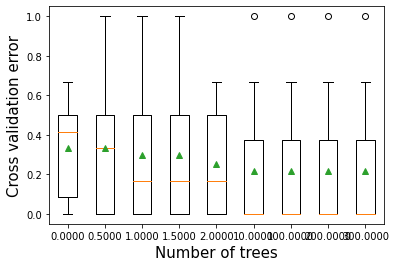

In [217]:
def get_models():
    models = dict()
    # explore 'reg_lambda' from 0.1 to 2 in 0.1 increments
    for i in [0,0.5,1.0,1.5,2,10,100,200,300]:
        key = '%.4f' % i
        models[key] = xgb.XGBClassifier(reg_lambda=i,random_state=1,scale_pos_weight=scale_pos_weight)
    return models



# define custom scoring metric: false negative rate
def false_negative_rate(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    fnr = fn / (fn + tp)
    return fnr

# evaluate a given model using cross-validation
def evaluate_model(model, X_train, y_train):
    # define the evaluation procedure
    cv = StratifiedKFold(n_splits=10,shuffle=True,random_state=1)
    # evaluate the model and collect the results
    scoring = make_scorer(false_negative_rate, greater_is_better=True)
    scores = cross_val_score(model, X_train, y_train, scoring=scoring, cv=cv, n_jobs=-1)
    return scores

# get the models to evaluate
models = get_models()

# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    # evaluate the model
    scores = evaluate_model(model, X_train, y_train)
    # store the results
    results.append(scores)
    names.append(name)
    # summarize the performance along the way
    print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))

# plot model performance for comparison
plt.boxplot(results, labels=names, showmeans=True)
plt.ylabel('Cross validation error', fontsize=15)
plt.xlabel('Number of trees', fontsize=15)

>0.0000 0.300 (0.340)
>10.0000 0.233 (0.249)
>20.0000 0.167 (0.258)
>30.0000 0.167 (0.258)
>40.0000 0.117 (0.236)
>50.0000 0.117 (0.236)
>60.0000 0.117 (0.236)
>70.0000 0.067 (0.200)
>80.0000 0.067 (0.200)
>90.0000 0.067 (0.200)
>100.0000 0.117 (0.236)
>110.0000 0.117 (0.236)
>120.0000 0.117 (0.236)


Text(0.5, 0, 'Number of trees')

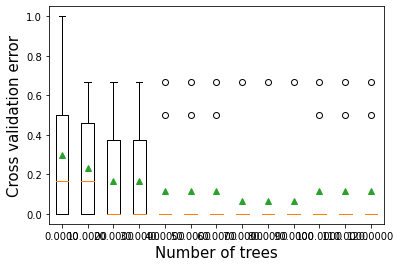

In [218]:
def get_models():
    models = dict()
    # explore gamma from 0.1 to 2 in 0.1 increments
    for i in np.arange(0,121,10):
        key = '%.4f' % i
        models[key] = xgb.XGBClassifier(gamma=i,random_state=1,scale_pos_weight=scale_pos_weight)
    return models



# define custom scoring metric: false negative rate
def false_negative_rate(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    fnr = fn / (fn + tp)
    return fnr

# evaluate a given model using cross-validation
def evaluate_model(model, X_train, y_train):
    # define the evaluation procedure
    cv = StratifiedKFold(n_splits=10,shuffle=True,random_state=1)
    # evaluate the model and collect the results
    scoring = make_scorer(false_negative_rate, greater_is_better=True)
    scores = cross_val_score(model, X_train, y_train, scoring=scoring, cv=cv, n_jobs=-1)
    return scores

# get the models to evaluate
models = get_models()

# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    # evaluate the model
    scores = evaluate_model(model, X_train, y_train)
    # store the results
    results.append(scores)
    names.append(name)
    # summarize the performance along the way
    print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))

# plot model performance for comparison
plt.boxplot(results, labels=names, showmeans=True)
plt.ylabel('Cross validation error', fontsize=15)
plt.xlabel('Number of trees', fontsize=15)

>0.1000 0.280 (0.271)
>0.2000 0.200 (0.253)
>0.3000 0.200 (0.253)
>0.4000 0.200 (0.253)
>0.5000 0.160 (0.196)
>0.6000 0.200 (0.179)
>0.7000 0.200 (0.179)
>0.8000 0.200 (0.179)
>0.9000 0.200 (0.179)
>1.0000 0.200 (0.179)


Text(0.5, 0, 'Number of trees')

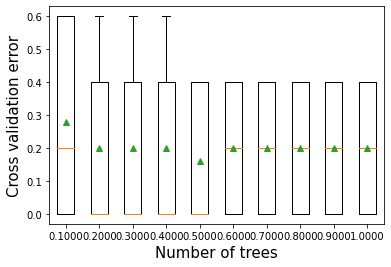

In [219]:
def get_models():
    models = dict()
    # explore learning rates from 0.1 to 2 in 0.1 increments
    for i in [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]:
        key = '%.4f' % i
        models[key] = xgb.XGBClassifier(colsample_bytree=i,random_state=1,scale_pos_weight=scale_pos_weight)
    return models


# define custom scoring metric: false negative rate
def false_negative_rate(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    fnr = fn / (fn + tp)
    return fnr

# evaluate a given model using cross-validation
def evaluate_model(model, X_train, y_train):
    # define the evaluation procedure
    cv = StratifiedKFold(n_splits=5,shuffle=True,random_state=1)
    # evaluate the model and collect the results
    scoring = make_scorer(false_negative_rate, greater_is_better=True)
    scores = cross_val_score(model, X_train, y_train, scoring=scoring, cv=cv, n_jobs=-1)
    return scores

# get the models to evaluate
models = get_models()

# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    # evaluate the model
    scores = evaluate_model(model, X_train, y_train)
    # store the results
    results.append(scores)
    names.append(name)
    # summarize the performance along the way
    print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))

# plot model performance for comparison
plt.boxplot(results, labels=names, showmeans=True)
plt.ylabel('Cross validation error', fontsize=15)
plt.xlabel('Number of trees', fontsize=15)

>0.1000 0.200 (0.253)
>0.2000 0.280 (0.349)
>0.3000 0.280 (0.349)
>0.4000 0.200 (0.179)
>0.5000 0.240 (0.233)
>0.6000 0.200 (0.179)
>0.7000 0.240 (0.150)
>0.8000 0.320 (0.204)
>0.9000 0.240 (0.196)
>1.0000 0.200 (0.179)


Text(0.5, 0, 'Number of trees')

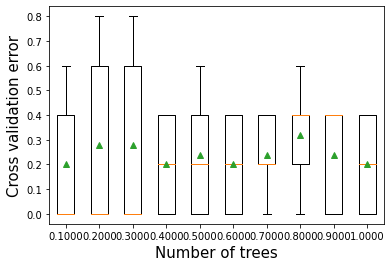

In [220]:
def get_models():
    models = dict()
    # explore learning rates from 0.1 to 2 in 0.1 increments
    for i in [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]:
        key = '%.4f' % i
        models[key] = xgb.XGBClassifier(subsample=i,random_state=1,scale_pos_weight=scale_pos_weight)
    return models


# define custom scoring metric: false negative rate
def false_negative_rate(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    fnr = fn / (fn + tp)
    return fnr

# evaluate a given model using cross-validation
def evaluate_model(model, X_train, y_train):
    # define the evaluation procedure
    cv = StratifiedKFold(n_splits=5,shuffle=True,random_state=1)
    # evaluate the model and collect the results
    scoring = make_scorer(false_negative_rate, greater_is_better=True)
    scores = cross_val_score(model, X_train, y_train, scoring=scoring, cv=cv, n_jobs=-1)
    return scores

# get the models to evaluate
models = get_models()

# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    # evaluate the model
    scores = evaluate_model(model, X_train, y_train)
    # store the results
    results.append(scores)
    names.append(name)
    # summarize the performance along the way
    print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))

# plot model performance for comparison
plt.boxplot(results, labels=names, showmeans=True)
plt.ylabel('Cross validation error', fontsize=15)
plt.xlabel('Number of trees', fontsize=15)

In [196]:

param_grid = {
    'n_estimators': [50,60,70,80,90,100,110],
    'max_depth': [5,10,15,20,25,30,35,40],
    'learning_rate': [0.4,0.5,0.6],
    'gamma': [60,70,80,90,100,110,120],
    'reg_lambda': [50,60,70,80,90,100,110],
    'subsample': [0.2, 0.3,0.4,0.45,0.5],
    'scale_pos_weight': [scale_pos_weight],
    'colsample_bytree': [0.7,0.75,0.8,0.85,0.9]
}

xgb_model = xgb.XGBClassifier(objective = 'binary:logistic',random_state=1,use_label_encoder=False)




cv = StratifiedKFold(n_splits=5,shuffle=True,random_state=1)
rs_cv = RandomizedSearchCV(estimator=xgb_model, 
                           random_state=1, 
                           param_distributions=param_grid, 
                           scoring=['recall','accuracy'],
                           refit='recall',
                           cv=cv,
                          n_jobs=-1,
                          verbose=2,
                          n_iter=1000)

grid_result = rs_cv.fit(X_train, y_train)
print("Best Accuracy Score: %f" % (grid_result.cv_results_['mean_test_accuracy'][grid_result.best_index_]))
print("Best Recall Score: %f" % (grid_result.cv_results_['mean_test_recall'][grid_result.best_index_]))
print("Best Hyperparameters: ", grid_result.best_params_)

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
[CV] END colsample_bytree=0.85, gamma=60, learning_rate=0.6, max_depth=15, n_estimators=90, reg_lambda=60, scale_pos_weight=15.56, subsample=0.4; total time=   0.0s
[CV] END colsample_bytree=0.7, gamma=60, learning_rate=0.6, max_depth=30, n_estimators=60, reg_lambda=70, scale_pos_weight=15.56, subsample=0.4; total time=   0.0s
[CV] END colsample_bytree=0.75, gamma=110, learning_rate=0.5, max_depth=20, n_estimators=70, reg_lambda=90, scale_pos_weight=15.56, subsample=0.5; total time=   0.0s
[CV] END colsample_bytree=0.75, gamma=110, learning_rate=0.5, max_depth=20, n_estimators=70, reg_lambda=90, scale_pos_weight=15.56, subsample=0.5; total time=   0.0s
[CV] END colsample_bytree=0.7, gamma=90, learning_rate=0.5, max_depth=40, n_estimators=80, reg_lambda=90, scale_pos_weight=15.56, subsample=0.2; total time=   0.0s
[CV] END colsample_bytree=0.7, gamma=90, learning_rate=0.5, max_depth=40, n_estimators=80, reg_lambda=90, scal

[CV] END colsample_bytree=0.8, gamma=70, learning_rate=0.5, max_depth=10, n_estimators=50, reg_lambda=50, scale_pos_weight=15.56, subsample=0.45; total time=   0.0s[CV] END colsample_bytree=0.85, gamma=60, learning_rate=0.6, max_depth=15, n_estimators=90, reg_lambda=60, scale_pos_weight=15.56, subsample=0.4; total time=   0.0s
[CV] END colsample_bytree=0.75, gamma=70, learning_rate=0.5, max_depth=25, n_estimators=70, reg_lambda=60, scale_pos_weight=15.56, subsample=0.4; total time=   0.0s
[CV] END colsample_bytree=0.8, gamma=100, learning_rate=0.5, max_depth=30, n_estimators=110, reg_lambda=90, scale_pos_weight=15.56, subsample=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=100, learning_rate=0.5, max_depth=30, n_estimators=110, reg_lambda=90, scale_pos_weight=15.56, subsample=0.5; total time=   0.1s
[CV] END colsample_bytree=0.9, gamma=80, learning_rate=0.5, max_depth=40, n_estimators=70, reg_lambda=100, scale_pos_weight=15.56, subsample=0.4; total time=   0.0s
[CV] END 

[CV] END colsample_bytree=0.9, gamma=110, learning_rate=0.4, max_depth=25, n_estimators=60, reg_lambda=90, scale_pos_weight=15.56, subsample=0.4; total time=   0.0s[CV] END colsample_bytree=0.7, gamma=60, learning_rate=0.6, max_depth=30, n_estimators=60, reg_lambda=70, scale_pos_weight=15.56, subsample=0.4; total time=   0.0s
[CV] END colsample_bytree=0.75, gamma=70, learning_rate=0.5, max_depth=25, n_estimators=70, reg_lambda=60, scale_pos_weight=15.56, subsample=0.4; total time=   0.0s
[CV] END colsample_bytree=0.75, gamma=110, learning_rate=0.5, max_depth=20, n_estimators=70, reg_lambda=90, scale_pos_weight=15.56, subsample=0.5; total time=   0.0s
[CV] END colsample_bytree=0.75, gamma=110, learning_rate=0.5, max_depth=20, n_estimators=70, reg_lambda=90, scale_pos_weight=15.56, subsample=0.5; total time=   0.0s
[CV] END colsample_bytree=0.85, gamma=100, learning_rate=0.6, max_depth=20, n_estimators=50, reg_lambda=100, scale_pos_weight=15.56, subsample=0.3; total time=   0.0s
[CV] END

[CV] END colsample_bytree=0.8, gamma=120, learning_rate=0.5, max_depth=40, n_estimators=90, reg_lambda=50, scale_pos_weight=15.56, subsample=0.2; total time=   0.0s
[CV] END colsample_bytree=0.9, gamma=80, learning_rate=0.5, max_depth=30, n_estimators=80, reg_lambda=80, scale_pos_weight=15.56, subsample=0.45; total time=   0.0s
[CV] END colsample_bytree=0.7, gamma=70, learning_rate=0.4, max_depth=5, n_estimators=90, reg_lambda=100, scale_pos_weight=15.56, subsample=0.2; total time=   0.0s
[CV] END colsample_bytree=0.7, gamma=70, learning_rate=0.4, max_depth=5, n_estimators=90, reg_lambda=100, scale_pos_weight=15.56, subsample=0.2; total time=   0.0s
[CV] END colsample_bytree=0.7, gamma=70, learning_rate=0.4, max_depth=5, n_estimators=90, reg_lambda=100, scale_pos_weight=15.56, subsample=0.2; total time=   0.0s
[CV] END colsample_bytree=0.85, gamma=110, learning_rate=0.5, max_depth=20, n_estimators=110, reg_lambda=70, scale_pos_weight=15.56, subsample=0.45; total time=   0.1s
[CV] END c

[CV] END colsample_bytree=0.75, gamma=100, learning_rate=0.6, max_depth=25, n_estimators=50, reg_lambda=70, scale_pos_weight=15.56, subsample=0.4; total time=   0.0s
[CV] END colsample_bytree=0.9, gamma=120, learning_rate=0.6, max_depth=40, n_estimators=80, reg_lambda=100, scale_pos_weight=15.56, subsample=0.3; total time=   0.0s
[CV] END colsample_bytree=0.9, gamma=120, learning_rate=0.6, max_depth=40, n_estimators=80, reg_lambda=100, scale_pos_weight=15.56, subsample=0.3; total time=   0.0s
[CV] END colsample_bytree=0.9, gamma=120, learning_rate=0.6, max_depth=40, n_estimators=80, reg_lambda=100, scale_pos_weight=15.56, subsample=0.3; total time=   0.0s
[CV] END colsample_bytree=0.9, gamma=120, learning_rate=0.6, max_depth=40, n_estimators=80, reg_lambda=100, scale_pos_weight=15.56, subsample=0.3; total time=   0.0s
[CV] END colsample_bytree=0.9, gamma=120, learning_rate=0.6, max_depth=40, n_estimators=80, reg_lambda=100, scale_pos_weight=15.56, subsample=0.3; total time=   0.0s
[CV]

[CV] END colsample_bytree=0.9, gamma=90, learning_rate=0.4, max_depth=10, n_estimators=110, reg_lambda=60, scale_pos_weight=15.56, subsample=0.4; total time=   0.1s
[CV] END colsample_bytree=0.9, gamma=90, learning_rate=0.4, max_depth=10, n_estimators=110, reg_lambda=60, scale_pos_weight=15.56, subsample=0.4; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=120, learning_rate=0.4, max_depth=10, n_estimators=80, reg_lambda=60, scale_pos_weight=15.56, subsample=0.45; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=120, learning_rate=0.4, max_depth=10, n_estimators=80, reg_lambda=60, scale_pos_weight=15.56, subsample=0.45; total time=   0.0s
[CV] END colsample_bytree=0.8, gamma=120, learning_rate=0.4, max_depth=10, n_estimators=80, reg_lambda=60, scale_pos_weight=15.56, subsample=0.45; total time=   0.0s
[CV] END colsample_bytree=0.8, gamma=120, learning_rate=0.4, max_depth=10, n_estimators=80, reg_lambda=60, scale_pos_weight=15.56, subsample=0.45; total time=   0.0s
[CV] E

[CV] END colsample_bytree=0.85, gamma=100, learning_rate=0.4, max_depth=25, n_estimators=80, reg_lambda=100, scale_pos_weight=15.56, subsample=0.5; total time=   0.1sBest Accuracy Score: 0.930003
Best Recall Score: 0.960000
Best Hyperparameters:  {'subsample': 0.45, 'scale_pos_weight': 15.56, 'reg_lambda': 100, 'n_estimators': 80, 'max_depth': 35, 'learning_rate': 0.5, 'gamma': 70, 'colsample_bytree': 0.7}


In [197]:
cv_results_df = pd.DataFrame(grid_result.cv_results_)

In [200]:
subset_df = cv_results_df[(cv_results_df['mean_test_accuracy'] > 0.93) & (cv_results_df['mean_test_recall'] > 0.92)]
subset_df[['param_subsample','param_scale_pos_weight','param_reg_lambda','param_n_estimators','param_max_depth',
          'param_learning_rate', 'param_gamma', 'param_colsample_bytree']]

,param_subsample,param_scale_pos_weight,param_reg_lambda,param_n_estimators,param_max_depth,param_learning_rate,param_gamma,param_colsample_bytree
564,0.45,15.56,100,80,35,0.5,70,0.7


In [227]:
model = xgb.XGBClassifier(objective='binary:logistic', use_label_encoder=False, max_depth=35, n_estimators=80, learning_rate=0.5, scale_pos_weight=scale_pos_weight, subsample=0.45, gamma=70, reg_lambda=100, colsample_bytree=0.7, random_state=1).fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
confusion_mat = confusion_matrix(y_test, y_pred)

print("Accuracy:", accuracy)
print("Recall:", recall)
print("Precision:", precision)
print("Confusion Matrix:")
print(confusion_mat)

Accuracy: 0.8770685579196218
Recall: 0.76
Precision: 0.2923076923076923
Confusion Matrix:
[[352  46]
 [  6  19]]


In [228]:
misclassified_players = [nba_2018_2019.loc[i, 'Player'] for i in range(len(y_pred)) if y_pred[i] == 0 and y_test.iloc[i] == 1]

print("Players predicted as 0 but actually belong to class 1:")
for player in misclassified_players:
    print(player)

Players predicted as 0 but actually belong to class 1:
Bam Adebayo
Rudy Gobert
Kyle Lowry
Chris Paul
Domantas Sabonis
Jayson Tatum


In [229]:
misclassified_players = [nba_2018_2019.loc[i, 'Player'] for i in range(len(y_pred)) if y_pred[i] == 1 and y_test.iloc[i] == 0]

print("Players predicted as 1 but actually belong to class 0:")
for player in misclassified_players:
    print(player)

Players predicted as 1 but actually belong to class 0:
Harrison Barnes
Tim Hardaway Jr.
Tobias Harris
LaMarcus Aldridge
Deandre Ayton
Bradley Beal
Bojan Bogdanović
Clint Capela
Jordan Clarkson
John Collins
Mike Conley
DeMarcus Cousins
Stephen Curry
DeMar DeRozan
Spencer Dinwiddie
Andre Drummond
Kevin Durant
De'Aaron Fox
Danilo Gallinari
Paul George
Eric Gordon
Blake Griffin
Montrezl Harrell
Buddy Hield
Jrue Holiday
Kyrie Irving
Kyle Kuzma
Zach LaVine
Kevin Love
Lauri Markkanen
CJ McCollum
Jamal Murray
Victor Oladipo
Julius Randle
J.J. Redick
Josh Richardson
Derrick Rose
D'Angelo Russell
Collin Sexton
Klay Thompson
Karl-Anthony Towns
Nikola Vučević
John Wall
T.J. Warren
Andrew Wiggins
Lou Williams


In [235]:
model = xgb.XGBClassifier(objective='binary:logistic', use_label_encoder=False, max_depth=35, n_estimators=80, learning_rate=0.5, scale_pos_weight=scale_pos_weight, subsample=0.45, gamma=70, reg_lambda=100, colsample_bytree=0.7, random_state=1).fit(X_train, y_train)

y_pred = model.predict(X_train)

accuracy = accuracy_score(y_train, y_pred)
recall = recall_score(y_train, y_pred)
precision = precision_score(y_train, y_pred)
confusion_mat = confusion_matrix(y_train, y_pred)

print("Accuracy:", accuracy)
print("Recall:", recall)
print("Precision:", precision)
print("Confusion Matrix:")
print(confusion_mat)

Accuracy: 0.9251207729468599
Recall: 0.96
Precision: 0.4444444444444444
Confusion Matrix:
[[359  30]
 [  1  24]]


In [237]:
nba_2017_2018['Predicted'] = y_pred
nba_2017_2018['Actual'] = y_train

# False Positives: Predicted as 1 but actually 0
false_positives = nba_2017_2018[(nba_2017_2018['Predicted'] == 1) & (nba_2017_2018['Actual'] == 0)]

# False Negatives: Predicted as 0 but actually 1
false_negatives = nba_2017_2018[(nba_2017_2018['Predicted'] == 0) & (nba_2017_2018['Actual'] == 1)]

# Print the list of players
print("False Positives:")
print(false_positives['Player'])
print("False Negatives:")
print(false_negatives['Player'])

False Positives:
2            Eric Bledsoe
14          Tobias Harris
61        Carmelo Anthony
70        Harrison Barnes
90           Devin Booker
100          Jimmy Butler
137         DeMar DeRozan
143          Goran Dragić
153          Tyreke Evans
162         Evan Fournier
167            Marc Gasol
175          Aaron Gordon
176           Eric Gordon
186      Tim Hardaway Jr.
190           Gary Harris
201          Jrue Holiday
208         Dwight Howard
248           Zach LaVine
260            Kevin Love
273           CJ McCollum
285      Donovan Mitchell
293          Jamal Murray
319            Chris Paul
328    Kristaps Porziņģis
335           J.J. Redick
350       Dennis Schröder
392             John Wall
395           T.J. Warren
399        Andrew Wiggins
401          Lou Williams
Name: Player, dtype: object
False Negatives:
345    D'Angelo Russell
Name: Player, dtype: object


In [239]:
nba_2018_2019.loc[nba_2018_2019['Player'] == "D'Angelo Russell"]

,Player,Age,G,GS,MP,FG,FGA,FG%,3P,3PA,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,AS_NY
364,D'Angelo Russell,22,81,81,30.2,8.1,18.7,43.4,2.9,7.8,...,0.7,3.2,3.9,7.0,1.2,0.2,3.1,1.7,21.1,0
